# Imports

In [1]:
# Common
import time
import os
import csv
import numpy as np

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image

# Ai Model
import tensorflow as tf

# For multithreading
from concurrent.futures import ThreadPoolExecutor

# Other
from IPython.display import clear_output as cls

# Constant

In [2]:
MODEL_PATH = '/kaggle/input/facenet-tensorflow/tensorflow2/default/2'

BASE_IMGS_PATH = '/kaggle/input/bill-gates-images/mbappe/cropped/'

# Model

In [31]:
class Profile:
    def __init__(self, imgs_paths, weightage, facenet_model_infer):
        self.imgs_paths = imgs_paths
        self.weightage = weightage
        self.facenet_model_infer = facenet_model_infer
        
        # Computed
        self.preprocessed_imgs = self._preprocess_imgs()
        self.embeddings = self._extract_embeddings()


    def _preprocess_img(self, image):
        """Preprocess image to FaceNet model type"""
        # Dimensions
        IMG_W = 160
        IMG_H = 160

        # Resize the image
        image = cv2.resize(image, dsize = (IMG_W, IMG_H))

        # Convert image stype or normalize
        image = image.astype(np.float32)/255.0

        return image
        
    def _preprocess_imgs(self):
        """Preprocess Multiple Images"""
        preprocessed_imgs = []
        
        for path in self.imgs_paths:
            # Read image
            image = plt.imread(path)

            # Preprocess image to normalize them into (160,160)
            preprocessed_img = self._preprocess_img(image)
            
            # Append processed images
            preprocessed_imgs.append(preprocessed_img)
        
        return preprocessed_imgs
    
    def _image_to_embedding(self, image: np.ndarray):
        """Generate face embedding from an image."""
        # Increase image dim
        image_input = image[np.newaxis,...] # (1, 160, 160, 3)

        # Perform inference using the callable function
        result = self.facenet_model_infer(tf.convert_to_tensor(image_input, dtype=tf.float32))

        # Extract result from output key (1,128)
        embedding = result['Bottleneck_BatchNorm'].numpy()

        # Normalize bedding using L2 norm.
        embedding /= np.linalg.norm(embedding, ord=2)

        return embedding
    
    def _extract_embeddings(self):
        """Generate all face profile embeddings"""
        # Store embeddings
        embeddings = np.empty(shape=(len(self.preprocessed_imgs), 128))

        # Generate embeddings
        for index, image in enumerate(self.preprocessed_imgs):
            # Generate embeddings
            embedding = self._image_to_embedding(image=image)

            # Store embeddings
            embeddings[index] = embedding
            
        return embeddings

    
    def plot_image_grid(self, images_per_row=5):
        """Plot Images Grid"""
        images = self.preprocessed_imgs
        total_images = len(self.preprocessed_imgs)
        
        # Ensure we don't exceed the available images or the limit of 50
        total_images = min(total_images, len(images))

        # Calculate the number of rows needed
        num_rows = (total_images + images_per_row - 1) // images_per_row

        # Create a figure with a grid of subplots
        fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

        # Flatten the axes array in case of more than one row
        axs = axs.ravel()

        for i in range(total_images):
            # Read and display the image
            img = images[i]
            axs[i].imshow(img)
            axs[i].axis('off')  # Turn off the axis for clean presentation

        # Turn off any remaining unused subplots (if total_images < images_per_row * num_rows)
        for j in range(total_images, len(axs)):
            axs[j].axis('off')

        # Show the grid of images
        plt.tight_layout()
        plt.show()
    

class Person:
    def __init__(self, front_profile_paths, side_profile_paths, extreme_side_profile_paths):
        # Load FaceNet Model
        model = tf.saved_model.load('/kaggle/input/facenet-tensorflow/tensorflow2/default/2')
        model_infer = model.signatures['serving_default']
        
        self.front_profile = Profile(imgs_paths=front_profile_paths, weightage=0.5, facenet_model_infer=model_infer)
        self.side_profile = Profile(imgs_paths=side_profile_paths, weightage=0.3, facenet_model_infer=model_infer)
        self.extreme_side_profile = Profile(imgs_paths=extreme_side_profile_paths, weightage=0.2, facenet_model_infer=model_infer)
        
    def generate_avg_embeddings(self):
        """Generate person's avg embedding"""
        # Concatenate all face profile embeddings
        total_embeddings = np.concatenate((self.front_profile.embeddings, 
                                           self.side_profile.embeddings, 
                                           self.extreme_side_profile.embeddings), axis=0)
        
        # Take average of embeddings
        avg_embedding = np.mean(total_embeddings, axis=0)
        return avg_embedding
    
    def generate_weighted_avg_embeddings(self):
        """Generate person's weighted average embedding"""
        # Splitting the embeddings into groups by type
        group1 = self.front_profile.embeddings
        group2 = self.side_profile.embeddings
        group3 = self.extreme_side_profile.embeddings

        # Assigning weights to each group
        weight1 = self.front_profile.weightage
        weight2 = self.side_profile.weightage
        weight3 = self.extreme_side_profile.weightage

        # Calculating the weighted embeddings
        weighted_sum = (np.sum(group1 * weight1, axis=0) +
                        np.sum(group2 * weight2, axis=0) +
                        np.sum(group3 * weight3, axis=0))

        # Calculating the total weight
        total_weight = (len(group1) * weight1 +
                        len(group2) * weight2 +
                        len(group3) * weight3)

        # Final weighted embedding
        weighted_embedding = weighted_sum / total_weight
        
        return weighted_embedding

    def generate_centered_and_scaled_embeddings(self):
        # Concatenate all face profile embeddings
        embeddings = np.concatenate((self.front_profile.embeddings, 
                                           self.side_profile.embeddings, 
                                           self.extreme_side_profile.embeddings), axis=0)
        
        # Convert the list of embeddings into a numpy array for easier processing
        embeddings_array = np.stack(embeddings)  # Shape: (n_samples, 128)
        
        # Step 1: Compute the mean vector
        mean_vector = np.mean(embeddings_array, axis=0)  # Shape: (128,)
        
        # Step 2: Compute the standard deviation vector
        std_vector = np.std(embeddings_array, axis=0)  # Shape: (128,)
        
        # Step 3: Center and scale embeddings
        centered_scaled_embeddings = (embeddings_array - mean_vector) / std_vector  # Shape: (n_samples, 128)
        
        # Step 4: Compute the final single embedding (mean embedding of centered and scaled data)
        final_embedding = np.mean(centered_scaled_embeddings, axis=0)  # Shape: (128,)

        return (mean_vector, std_vector, final_embedding)

    @property
    def total_embeddings(self):
        # Concatenate all face profile embeddings
        total_embeddings = np.concatenate((self.front_profile.embeddings, 
                                           self.side_profile.embeddings, 
                                           self.extreme_side_profile.embeddings), axis=0)
        return total_embeddings

# Utils

In [4]:
def get_image_paths(directory, valid_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".gif")):
    image_paths = []
    
    # Iterate over all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if file is an image based on its extension
            if file.lower().endswith(valid_extensions):
                # Append the full path of the image file to the list
                image_paths.append(os.path.join(root, file))
    
    return image_paths


def save_face_embeddings(embedding, filename):
    """Save Embedding as CSV"""
    # Ensure the embedding is a numpy array
    embedding = np.array(embedding)
    
    # Add file extension
    filename = f"{filename}.csv"
    
    # Save to CSV
    with open(filename, mode="w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(embedding)


def plt_img(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()
    

def image_to_embedding(image: np.ndarray, model_infer):
    """Generate face embedding from an image."""
    
    # Increase image dim
    image_input = image[np.newaxis,...] # (1, 160, 160, 3)
    
    # Perform inference using the callable function
    result = model_infer(tf.convert_to_tensor(image_input, dtype=tf.float32))
    
    # Extract result from output key (1,128)
    embedding = result['Bottleneck_BatchNorm'].numpy()
    
    # Normalize bedding using L2 norm.
    embedding /= np.linalg.norm(embedding, ord=2)
    
    return embedding


def cal_embeddings_dist(embedding_1: np.ndarray, embedding_2: np.ndarray) -> float:
    """
    Compares two embeddings and returns L2 norm of the distance vector.

    Args:
    - embedding_1: A 128-dimensional embedding vector.
    - embedding_2: A 128-dimensional embedding vector.

    Returns:
    - L2 norm of the distance vector
    """

    # Calculate the distance between the embeddings
    embedding_distance = embedding_1 - embedding_2

    # Calculate the L2 norm of the distance vector
    embedding_distance_norm = np.linalg.norm(embedding_distance)
    
    return embedding_distance_norm


def plot_image_grid(images, images_per_row=5, total_images=50):
    # Ensure we don't exceed the available images or the limit of 50
    total_images = min(total_images, len(images))
    
    # Calculate the number of rows needed
    num_rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    # Flatten the axes array in case of more than one row
    axs = axs.ravel()

    for i in range(total_images):
        # Read and display the image
        img = images[i]
        axs[i].imshow(img)
        axs[i].axis('off')  # Turn off the axis for clean presentation

    # Turn off any remaining unused subplots (if total_images < images_per_row * num_rows)
    for j in range(total_images, len(axs)):
        axs[j].axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()
    

def plt_embeddings(embedding):
    # Normalized embedding
    embedding_normalized = (embedding - np.min(embedding)) / (np.max(embedding) - np.min(embedding))
    
    # Plt barcode
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(embedding_normalized)), embedding_normalized)
    plt.show()

# Code

## Step1: Read & Visualize Images

In [19]:
# Read all images
front_image_paths = get_image_paths(f"{BASE_IMGS_PATH}front")
side_profile_image_paths = get_image_paths(f"{BASE_IMGS_PATH}side_profile")
extreme_side_profile_image_paths = get_image_paths(f"{BASE_IMGS_PATH}extreme_side_profile")

# Total samples
print(len(front_image_paths))
print(len(side_profile_image_paths))
print(len(extreme_side_profile_image_paths))

10
8
5


In [32]:
person = Person(front_profile_paths=front_image_paths, 
                side_profile_paths=side_profile_image_paths, 
                extreme_side_profile_paths=extreme_side_profile_image_paths)

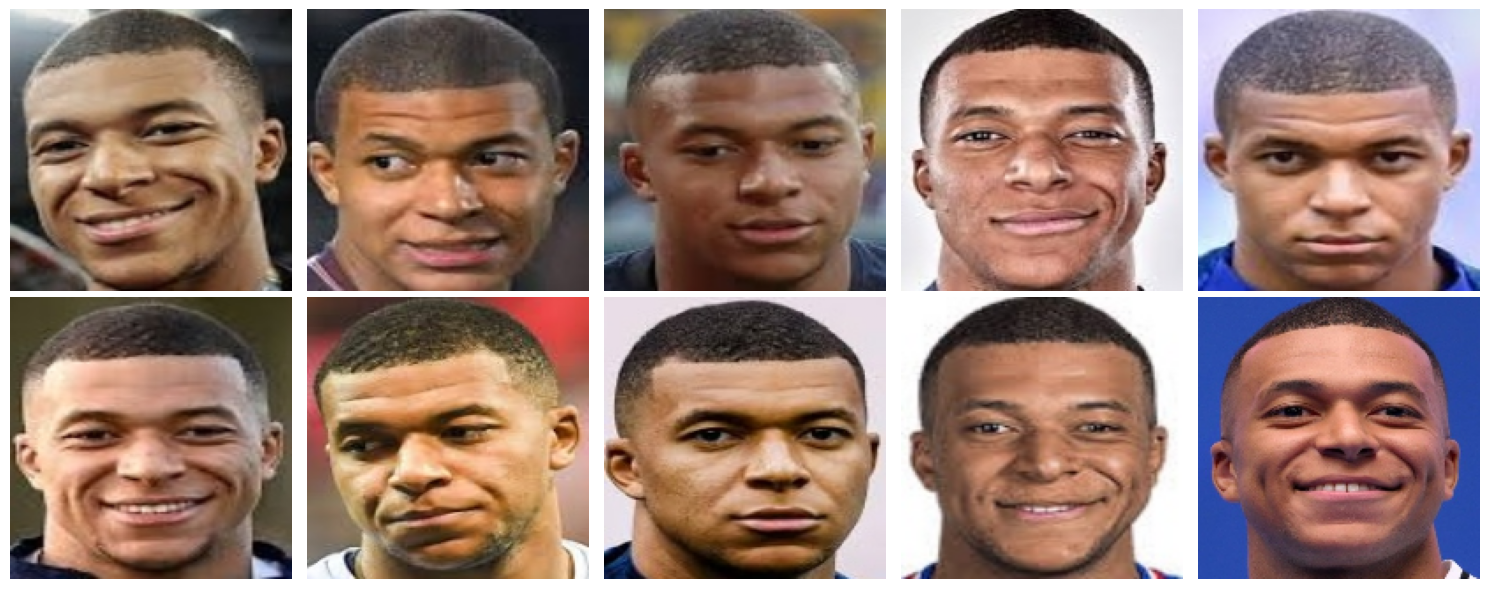

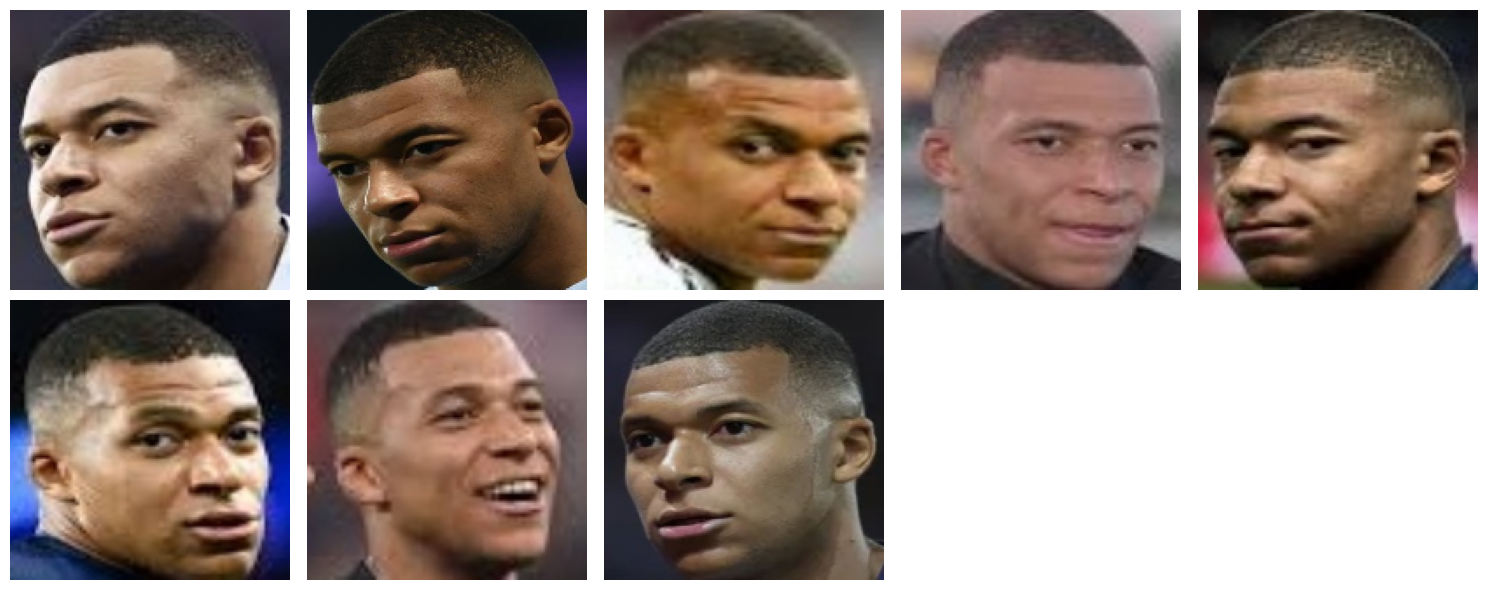

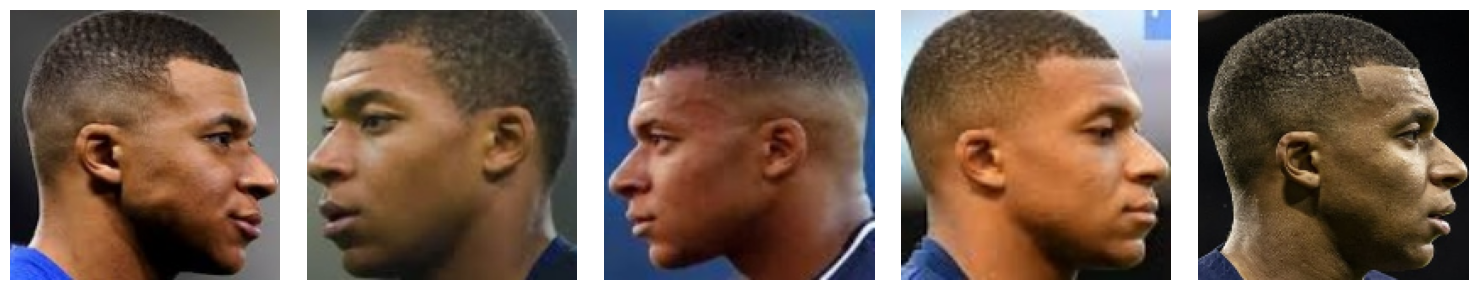

In [29]:
person.front_profile.plot_image_grid()
person.side_profile.plot_image_grid()
person.extreme_side_profile.plot_image_grid()

## Step2: Generate Avg Embedding

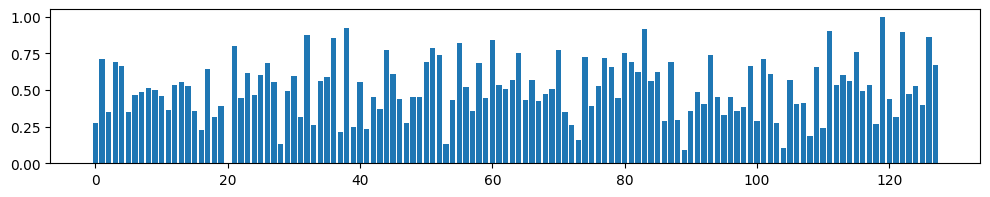

In [22]:
avg_embeddings = person.generate_avg_embeddings()
plt_embeddings(avg_embeddings)

## Step3: Generate Weighted Embeddings

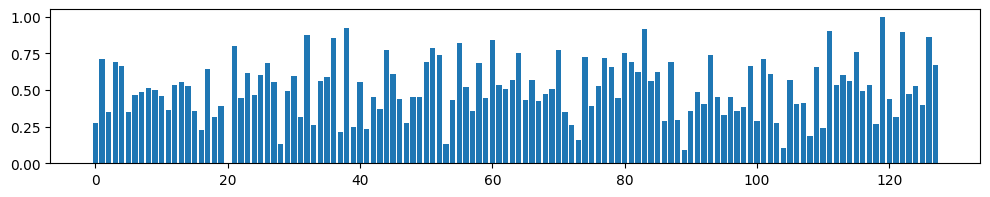

In [23]:
weighted_avg_embeddings = person.generate_weighted_avg_embeddings()
plt_embeddings(avg_embeddings)

## Step 4: Generate Centered & Scaled Embeddings

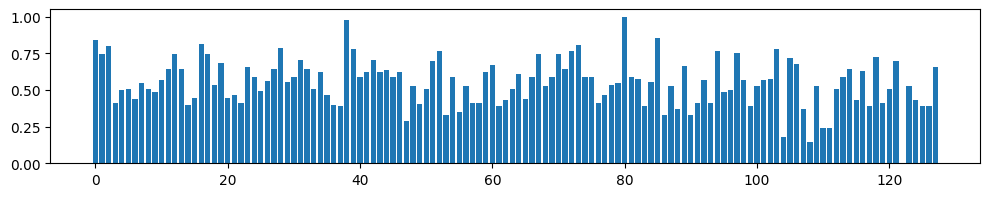

In [33]:
mean_vector, std_vector, centered_and_scaled_embeddings = person.generate_centered_and_scaled_embeddings()
plt_embeddings(centered_and_scaled_embeddings)

## Step4: Save Embeddings

In [10]:
# save_face_embeddings(avg_embeddings, filename="avg_face")

In [11]:
# save_face_embeddings(weighted_avg_embeddings, filename="weighted_avg_face")